<a href="https://colab.research.google.com/github/SudeUcarr/Denemece/blob/main/diabetic_wound_healing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()  # kaggle.json yükle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d laithjj/diabetic-foot-ulcer-dfu
!unzip -q diabetic-foot-ulcer-dfu.zip

!ls
!find . -maxdepth 3 -type d


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/laithjj/diabetic-foot-ulcer-dfu
License(s): unknown
 84% 108M/129M [00:00<00:00, 1.12GB/s]
100% 129M/129M [00:00<00:00, 1.01GB/s]
DFU  diabetic-foot-ulcer-dfu.zip  kaggle.json  sample_data
.
./.config
./.config/logs
./.config/logs/2026.01.16
./.config/configurations
./DFU
./DFU/Transfer-Learning images
./DFU/Transfer-Learning images/Wound Images2
./DFU/Transfer-Learning images/samples
./DFU/Transfer-Learning images/Wound Images
./DFU/Transfer-Learning images/internetSet
./DFU/Original Images
./DFU/Patches
./DFU/Patches/Abnormal(Ulcer)
./DFU/Patches/Normal(Healthy skin)
./DFU/TestSet
./sample_data


In [ ]:
!ls


DFU  diabetic-foot-ulcer-dfu.zip  kaggle.json  sample_data


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()


In [ ]:
def show_images(tdir):
    classlist=os.listdir(tdir)
    length=len(classlist)
    columns=5
    rows=int(np.ceil(length/columns))
    plt.figure(figsize=(20, rows * 4))
    for i, klass in enumerate(classlist):
        classpath=os.path.join(tdir, klass)
        imgpath=os.path.join(classpath, '1.jpg')
        img=plt.imread(imgpath)
        plt.subplot(rows, columns, i+1)
        plt.axis('off')
        plt.title(klass, color='blue', fontsize=12)
        plt.imshow(img)

In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [ ]:
class LRA(keras.callbacks.Callback):
    def __init__(self,model, base_model, patience,stop_patience, threshold, factor, dwell, batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.base_model=base_model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.batches=batches # number of training batch to runn per epoch
        self.initial_epoch=initial_epoch
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.ask_epoch_initial=ask_epoch # save this value to restore if restarting training
        # callback variables
        self.count=0 # how many times lr has been reduced without improvement
        self.stop_count=0
        self.best_epoch=1   # epoch with the lowest loss
        self.initial_lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it
        self.highest_tracc=0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss=np.inf # set lowest validation loss to infinity initially
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights=self.model.get_weights()   # save initial weights if they have to get restored

    def on_train_begin(self, logs=None):
        if self.base_model != None:
            status=base_model.trainable
            if status:
                msg=' initializing callback starting train with base_model trainable'
            else:
                msg='initializing callback starting training with base_model not trainable'
        else:
            msg='initialing callback and starting training'
        print_in_color (msg, (244, 252, 3), (55,65,80))
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80))
        self.start_time= time.time()

    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print_in_color(msg, (0,255,0), (55,65,80))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color(msg, (0,255,0), (55,65,80))

    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count

    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (acc-self.highest_tracc )*100/self.highest_tracc
            if acc>self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc=acc # set new highest training accuracy
                self.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.best_epoch=epoch + 1  # set the value of best epoch for this epoch
            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1: # lr should be adjusted
                    color=(245, 170, 66)
                    lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count=0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss
                else:
                    self.count=self.count +1 # increment patience counter
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (self.lowest_vloss- v_loss )*100/self.lowest_vloss
            if v_loss< self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss
                self.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved
                self.stop_count=0
                color=(0,255,0)
                self.best_epoch=epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count>=self.patience-1: # need to adjust lr
                    color=(245, 170, 66)
                    lr=lr * self.factor # adjust the learning rate
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else:
                    self.count =self.count +1 # increment the patience counter
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else:
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    if base_model.trainable:
                        msg='enter H to halt  or an integer for number of epochs to run then ask again'
                    else:
                        msg='enter H to halt ,F to fine tune model, or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    elif ans == 'F' or ans=='f':
                        if base_model.trainable:
                            msg='base_model is already set as trainable'
                        else:
                            msg='setting base_model as trainable for fine tuning of model'
                            self.base_model.trainable=True
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))
                        self.count=0
                        self.stop_count=0
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial

                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [ ]:
def saver(save_path, model, model_name, subject, accuracy,img_size, scalar, generator):
    # first save the model
    save_id = model_name + '-' + subject + '-' + str(accuracy)[:str(accuracy).rfind('.')+3] + '.h5'
    model_save_loc=os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color ('model was saved as ' + model_save_loc, (0,255,0),(55,65,80))
    # now create the class_df and convert to csv file
    class_dict=generator.class_indices
    height=[]
    width=[]
    scale=[]
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    Index_series=pd.Series(list(class_dict.values()), name='class_index')
    Class_series=pd.Series(list(class_dict.keys()), name='class')
    Height_series=pd.Series(height, name='height')
    Width_series=pd.Series(width, name='width')
    Scale_series=pd.Series(scale, name='scale by')
    class_df=pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)
    csv_name='class_dict.csv'
    csv_save_loc=os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False)
    print_in_color ('class csv file was saved as ' + csv_save_loc, (0,255,0),(55,65,80))
    return model_save_loc, csv_save_loc

In [ ]:
def predictor(sdir, csv_path,  model_path, crop_image = False):
    # read in the csv file
    class_df=pd.read_csv(csv_path)
    img_height=int(class_df['height'].iloc[0])
    img_width =int(class_df['width'].iloc[0])
    img_size=(img_width, img_height)
    scale=class_df['scale by'].iloc[0]
    try:
        s=int(scale)
        s2=1
        s1=0
    except:
        split=scale.split('-')
        s1=float(split[1])
        s2=float(split[0].split('*')[1])
        print (s1,s2)
    path_list=[]
    paths=os.listdir(sdir)
    for f in paths:
        path_list.append(os.path.join(sdir,f))
    print (' Model is being loaded- this will take about 10 seconds')
    model=load_model(model_path)
    image_count=len(path_list)
    index_list=[]
    prob_list=[]
    cropped_image_list=[]
    good_image_count=0
    for i in range (image_count):
        img=cv2.imread(path_list[i])
        if crop_image == True:
            status, img=crop(img)
        else:
            status=True
        if status== True:
            good_image_count +=1
            img=cv2.resize(img, img_size)
            cropped_image_list.append(img)
            img=img*s2 - s1
            img=np.expand_dims(img, axis=0)
            p= np.squeeze (model.predict(img))
            index=np.argmax(p)
            prob=p[index]
            index_list.append(index)
            prob_list.append(prob)
    if good_image_count==1:
        class_name= class_df['class'].iloc[index_list[0]]
        probability= prob_list[0]
        img=cropped_image_list [0]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
        plt.imshow(img)
        return class_name, probability
    elif good_image_count == 0:
        return None, None
    most=0
    for i in range (len(index_list)-1):
        key= index_list[i]
        keycount=0
        for j in range (i+1, len(index_list)):
            nkey= index_list[j]
            if nkey == key:
                keycount +=1
        if keycount> most:
            most=keycount
            isave=i
    best_index=index_list[isave]
    psum=0
    bestsum=0
    for i in range (len(index_list)):
        psum += prob_list[i]
        if index_list[i]==best_index:
            bestsum += prob_list[i]
    img= cropped_image_list[isave]/255
    class_name=class_df['class'].iloc[best_index]
    plt.title(class_name, color='blue', fontsize=16)
    plt.axis('off')
    plt.imshow(img)
    return class_name, bestsum/image_count


In [ ]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    sample_list=[]
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        sample_count=len(group)
        if sample_count> max_size :
            samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    balance=list(df[column].value_counts())
    print (balance)
    return df

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os

def preprocess_new(sdir, train_split=0.7, val_split=0.15, test_split=0.15):
    filepaths = []
    labels = []
    # sınıfları dolaş
    for klass in os.listdir(sdir):
        classpath = os.path.join(sdir, klass)
        for f in os.listdir(classpath):
            filepaths.append(os.path.join(classpath, f))
            labels.append(klass)
    df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

    # 1. aşama: eğitim setini ayır
    train_df, remainder_df = train_test_split(
        df,
        train_size=train_split,
        shuffle=True,
        random_state=123,
        stratify=df['labels']
    )

    # 2. aşama: doğrulama ve test seti ayır
    # val_oranı = val/(val+test)
    val_ratio = val_split / (val_split + test_split)
    valid_df, test_df = train_test_split(
        remainder_df,
        test_size=1 - val_ratio,  # test_ratio = test/(val+test)
        shuffle=True,
        random_state=123,
        stratify=remainder_df['labels']
    )

    return train_df.reset_index(drop=True), valid_df.reset_index(drop=True), test_df.reset_index(drop=True)


In [ ]:
sdir = './DFU/Patches'

train_df2, valid_df2, test_df2 = preprocess_new(
    sdir,
    train_split=0.70,
    val_split=0.15,
    test_split=0.15
)

print(f'Train: {len(train_df2)}, Valid: {len(valid_df2)}, Test: {len(test_df2)}')
print('Train class distribution:')
print(train_df2["labels"].value_counts())
print('Valid class distribution:')
print(valid_df2["labels"].value_counts())
print('Test class distribution:')
print(test_df2["labels"].value_counts())


Train: 738, Valid: 158, Test: 159
Train class distribution:
labels
Normal(Healthy skin)    380
Abnormal(Ulcer)         358
Name: count, dtype: int64
Valid class distribution:
labels
Normal(Healthy skin)    81
Abnormal(Ulcer)         77
Name: count, dtype: int64
Test class distribution:
labels
Normal(Healthy skin)    82
Abnormal(Ulcer)         77
Name: count, dtype: int64


In [ ]:
def balance(train_df, max_samples, min_samples, column, working_dir, image_size): #kullanılmıyor
    train_df=train_df.copy()
    train_df=trim(train_df, max_samples, min_samples, column)

    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)

    for label in train_df['labels'].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path)

    total=0
    gen=ImageDataGenerator(horizontal_flip=True, rotation_range=20, width_shift_range=.2,
                           height_shift_range=.2, zoom_range=.2)

    groups=train_df.groupby('labels')
    for label in train_df['labels'].unique():
        group=groups.get_group(label)
        sample_count=len(group)
        if sample_count < max_samples:
            aug_img_count=0
            delta=max_samples-sample_count
            target_dir=os.path.join(aug_dir, label)

            aug_gen=gen.flow_from_dataframe(
                group, x_col='filepaths', y_col=None, target_size=image_size,
                class_mode=None, batch_size=1, shuffle=False,
                save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                save_format='jpg'
            )

            while aug_img_count < delta:
                images=next(aug_gen)
                aug_img_count += len(images)
            total += aug_img_count

    print('Total Augmented images created= ', total)

    if total>0:
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)
            flist=os.listdir(classpath)
            for f in flist:
                aug_fpaths.append(os.path.join(classpath,f))
                aug_labels.append(klass)
        aug_df=pd.DataFrame({'filepaths': aug_fpaths, 'labels': aug_labels})
        ndf=pd.concat([train_df, aug_df], axis=0).reset_index(drop=True)
    else:
        ndf=train_df

    print(list(ndf['labels'].value_counts()))
    return ndf

working_dir = r'./'
img_size=(224,224)

# max_samples'ı otomatik seç (daha sağlıklı)
max_samples = train_df2['labels'].value_counts().max()
min_samples = 0
column = 'labels'

#ndf = balance(train_df2, max_samples, min_samples, column, working_dir, img_size)


In [ ]:
channels = 3
batch_size = 30
img_shape = (img_size[0], img_size[1], channels)

length = len(test_df2)
test_batch_size = sorted(
    [int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80],
    reverse=True
)[0]
test_steps = int(length / test_batch_size)

print('test batch size:', test_batch_size, ' test steps:', test_steps)

def scalar(img):
    return img  # EfficientNet expects 0–255

trgen = ImageDataGenerator(
    preprocessing_function=scalar,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    brightness_range=(0.9, 1.1),
    fill_mode='nearest'
)

tvgen = ImageDataGenerator(preprocessing_function=scalar)

train_gen = trgen.flow_from_dataframe(
    train_df2,   # ✅ balance YOK
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = tvgen.flow_from_dataframe(
    valid_df2,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = tvgen.flow_from_dataframe(
    test_df2,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)

classes = list(train_gen.class_indices.keys())
class_count = len(classes)
train_steps = int(np.ceil(len(train_gen.labels) / batch_size))


test batch size: 53  test steps: 3
Found 738 validated image filenames belonging to 2 classes.
Found 158 validated image filenames belonging to 2 classes.
Found 159 validated image filenames belonging to 2 classes.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.array(sorted(train_df2['labels'].unique()))

weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_df2['labels'].values
)

class_weight = {cls: w for cls, w in zip(classes, weights)}
print(class_weight)


{np.str_('Abnormal(Ulcer)'): np.float64(1.0307262569832403), np.str_('Normal(Healthy skin)'): np.float64(0.9710526315789474)}


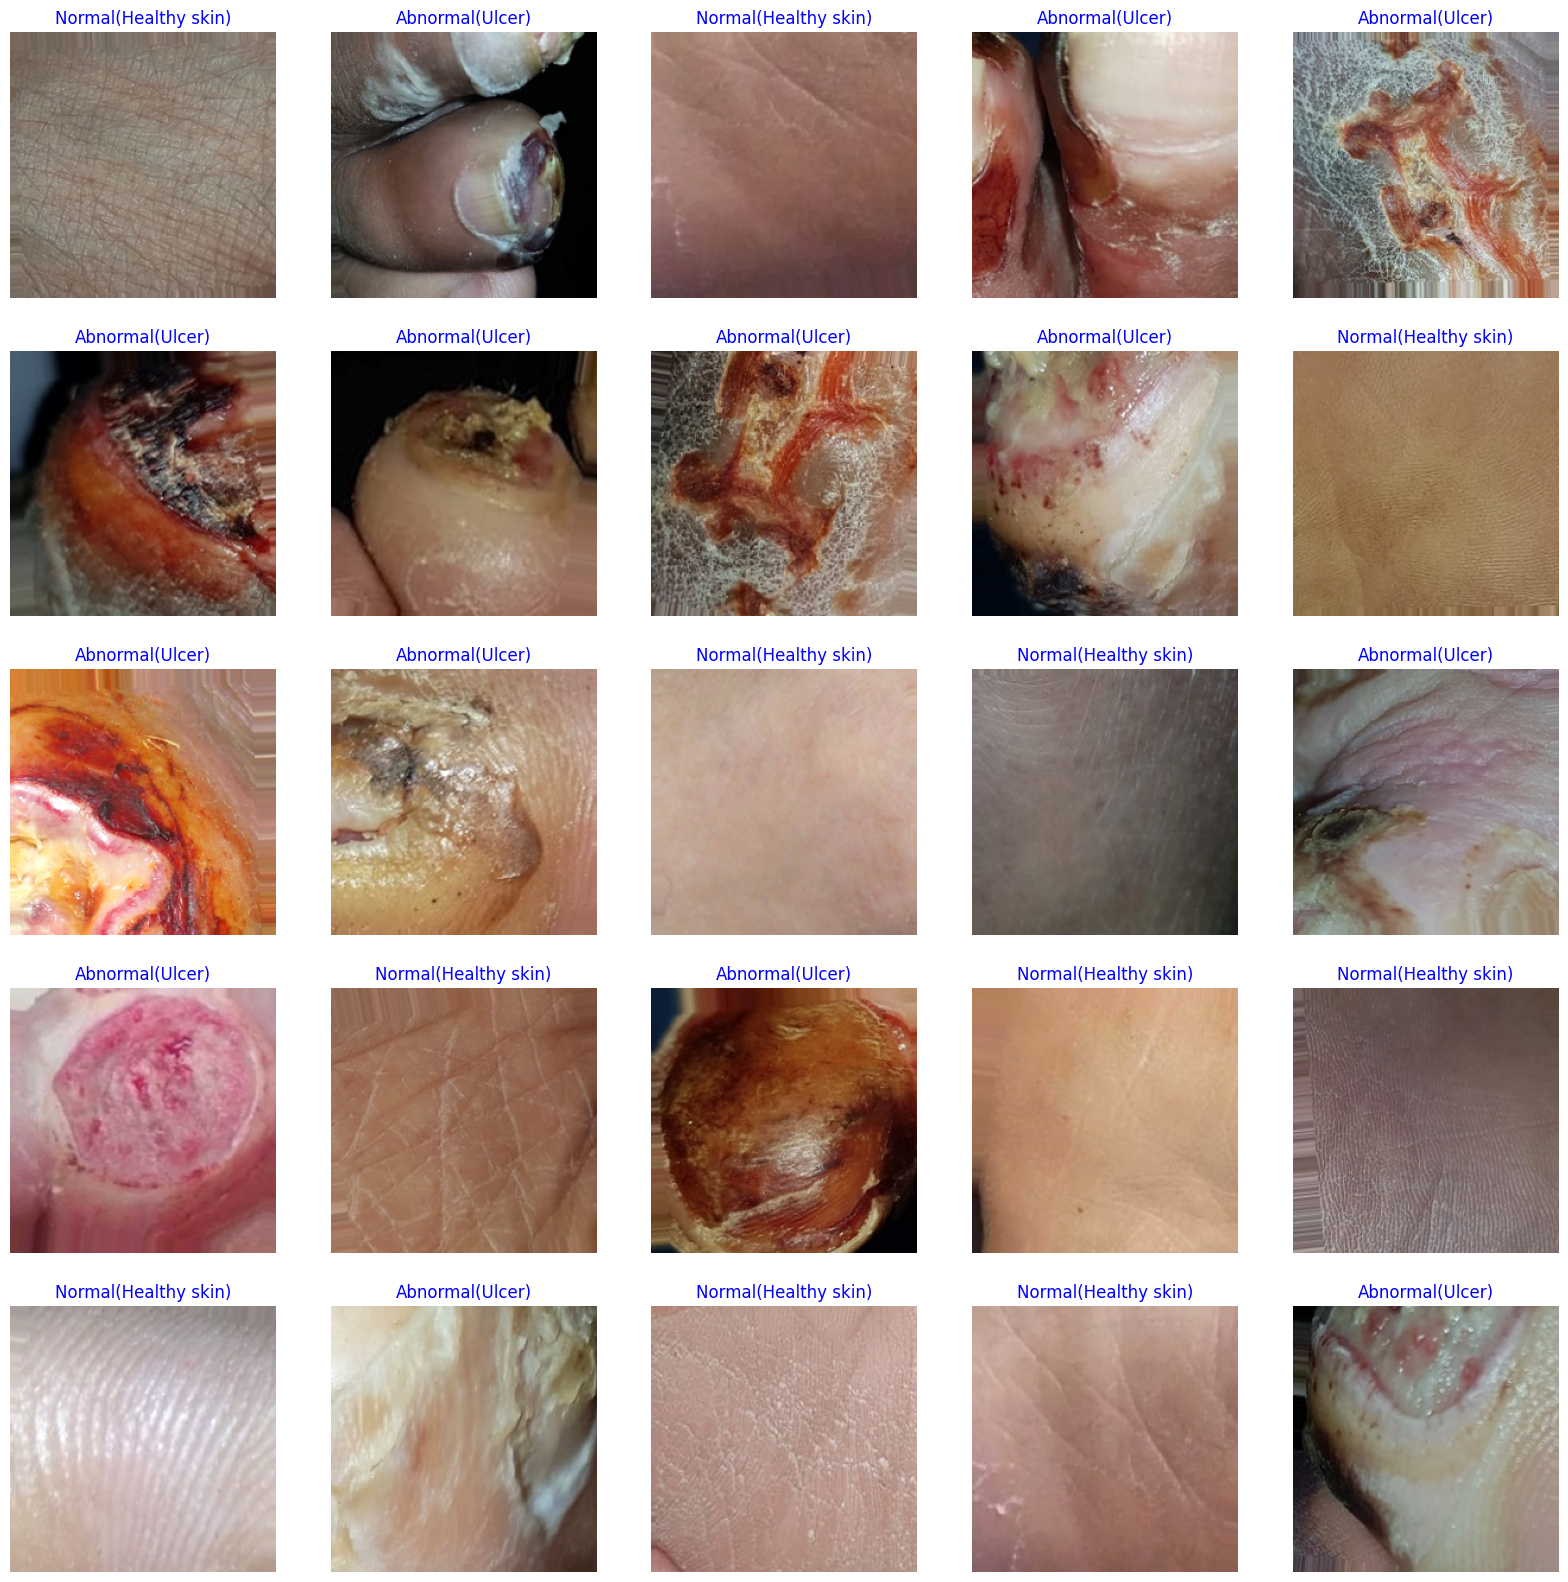

In [ ]:
show_image_samples(train_gen)

In [ ]:
img_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    pooling='max'
)

base_model.trainable = False


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.output
x = BatchNormalization(axis=-1)(x)
x = Dense(256, activation='relu',
          kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.45)(x)
output = Dense(class_count, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 11,183,665 (42.66 MB)

 Trainable params: 397,058 (1.51 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30,
    steps_per_epoch=train_steps,
    class_weight=class_weight,
    callbacks=[es, rlr],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 182s 6s/step - accuracy: 0.8238 - loss: 0.8276 - val_accuracy: 0.9747 - val_loss: 0.5192 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 149s 6s/step - accuracy: 0.9850 - loss: 0.5062 - val_accuracy: 1.0000 - val_loss: 0.4357 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 124s 5s/step - accuracy: 0.9866 - loss: 0.4618 - val_accuracy: 1.0000 - val_loss: 0.4228 - learning_rate: 0.0010
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.9916 - loss: 0.4403 - val_accuracy: 1.0000 - val_loss: 0.4146 - learning_rate: 0.0010
Epoch 5/30


KeyboardInterrupt: 

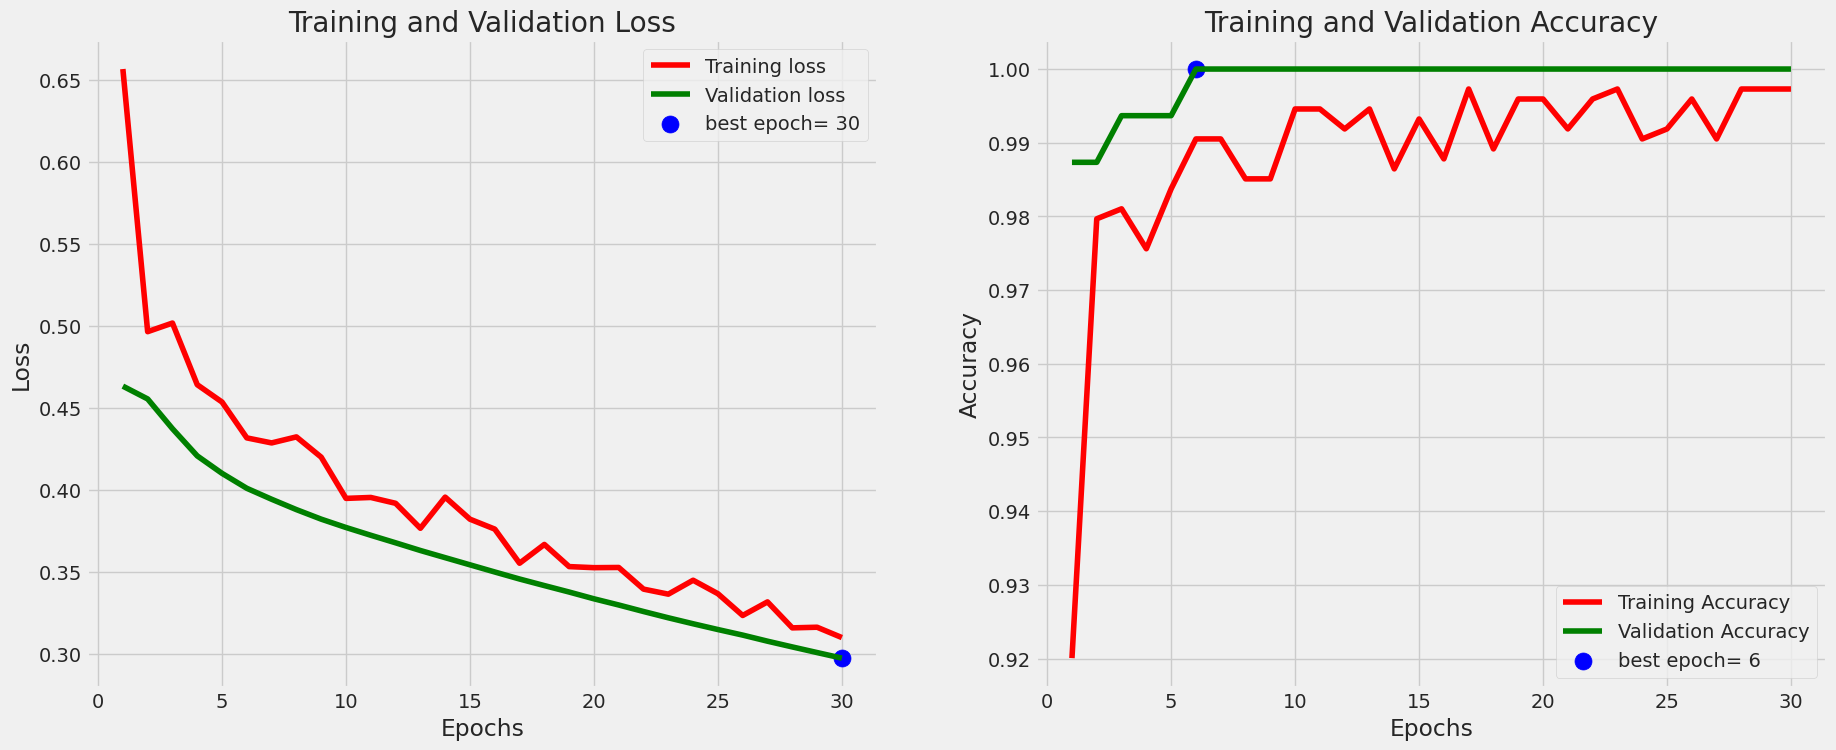

In [ ]:
tr_plot(history, 0)



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step


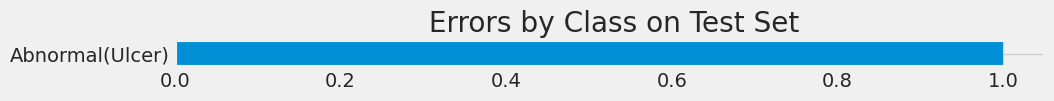

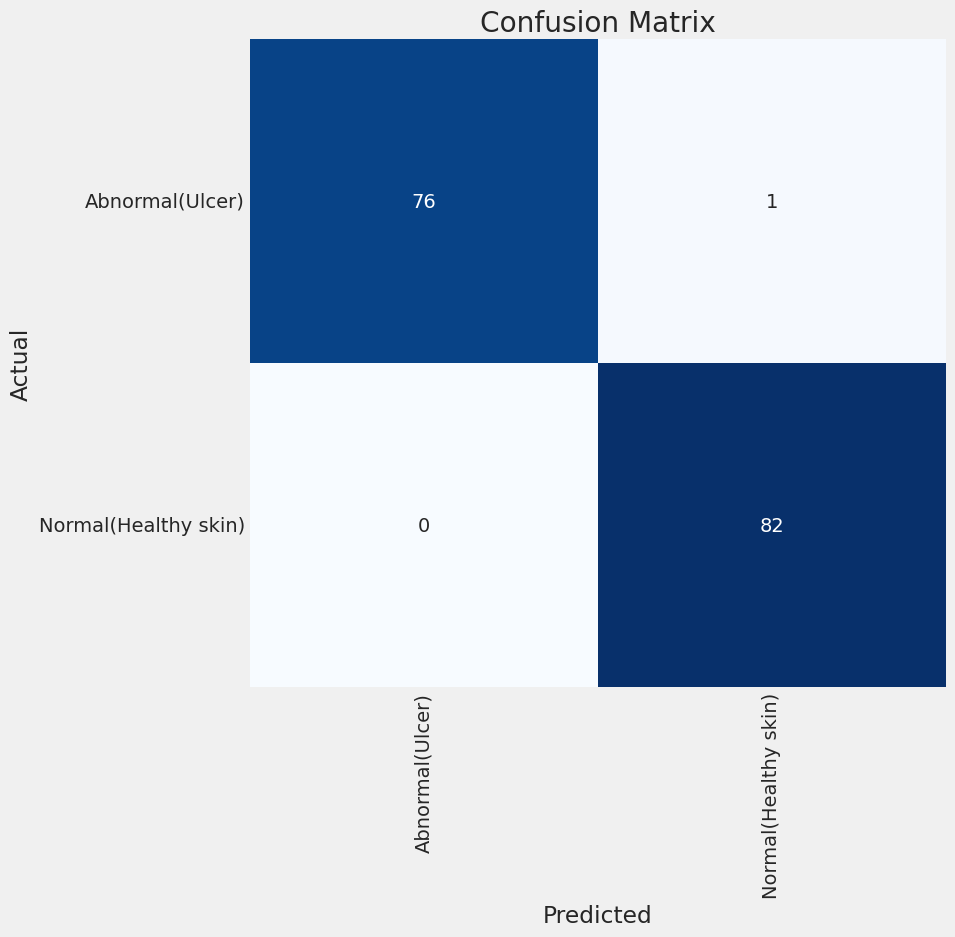

Classification Report:
----------------------
                       precision    recall  f1-score   support

     Abnormal(Ulcer)       1.00      0.99      0.99        77
Normal(Healthy skin)       0.99      1.00      0.99        82

            accuracy                           0.99       159
           macro avg       0.99      0.99      0.99       159
        weighted avg       0.99      0.99      0.99       159



In [ ]:
subject = 'ulcers'
print_code = 0
preds = model.predict(test_gen)
print_info(test_gen, preds, print_code, working_dir, subject)


In [ ]:
save_path = os.path.join(working_dir, 'saved')
os.makedirs(save_path, exist_ok=True)

acc = max(history.history['val_accuracy'])  # saver fonksiyonu acc değişkeni bekliyor
model_name = "effnetb3"

model_save_loc, csv_save_loc = saver(
    save_path=save_path,
    model=model,
    model_name=model_name,
    subject=subject,
    accuracy=acc,
    img_size=img_size,
    scalar="none",   # scalar fonksiyonunu yazıya dökmek yerine böyle bırakıyoruz
    generator=train_gen
)

print("MODEL PATH:", model_save_loc)
print("CSV PATH  :", csv_save_loc)


model was saved as ./saved/effnetb3-ulcers-1.0.h5

class csv file was saved as ./saved/class_dict.csv

MODEL PATH: ./saved/effnetb3-ulcers-1.0.h5
CSV PATH  : ./saved/class_dict.csv


In [ ]:
import os, pandas as pd

def build_df(sdir):
    filepaths, labels = [], []
    for klass in os.listdir(sdir):
        classpath = os.path.join(sdir, klass)
        for f in os.listdir(classpath):
            filepaths.append(os.path.join(classpath, f))
            labels.append(klass)
    return pd.DataFrame({"filepaths": filepaths, "labels": labels})

sdir = "./DFU/Patches"
df = build_df(sdir)
print("Total images:", len(df))
print(df["labels"].value_counts())
import hashlib
from tqdm import tqdm

def file_md5(p, block_size=1<<20):
    h = hashlib.md5()
    with open(p, 'rb') as f:
        while True:
            b = f.read(block_size)
            if not b:
                break
            h.update(b)
    return h.hexdigest()

tqdm.pandas()
df["md5"] = df["filepaths"].progress_apply(file_md5)

print("Unique md5:", df["md5"].nunique())
print("Duplicate count:", len(df) - df["md5"].nunique())

df_dedup = df.drop_duplicates(subset=["md5"]).reset_index(drop=True)
print("After dedup:", len(df_dedup))
print(df_dedup["labels"].value_counts())
from sklearn.model_selection import train_test_split

train_df2, remainder_df = train_test_split(
    df_dedup,
    train_size=0.70,
    shuffle=True,
    random_state=123,
    stratify=df_dedup["labels"]
)

val_ratio = 0.15 / (0.15 + 0.15)  # 0.5
valid_df2, test_df2 = train_test_split(
    remainder_df,
    train_size=val_ratio,
    shuffle=True,
    random_state=123,
    stratify=remainder_df["labels"]
)

train_df2 = train_df2.reset_index(drop=True)
valid_df2 = valid_df2.reset_index(drop=True)
test_df2  = test_df2.reset_index(drop=True)

print("Train:", len(train_df2), "Valid:", len(valid_df2), "Test:", len(test_df2))
train_md5 = set(train_df2["md5"])
valid_md5 = set(valid_df2["md5"])
test_md5  = set(test_df2["md5"])

print("MD5 train ∩ valid:", len(train_md5 & valid_md5))
print("MD5 train ∩ test :", len(train_md5 & test_md5))
print("MD5 valid ∩ test :", len(valid_md5 & test_md5))





Total images: 1055
labels
Normal(Healthy skin)    543
Abnormal(Ulcer)         512
Name: count, dtype: int64


In [ ]:

#DUUUUR
import hashlib
from tqdm import tqdm

def file_md5(p, block_size=1<<20):
    h = hashlib.md5()
    with open(p, 'rb') as f:
        while True:
            b = f.read(block_size)
            if not b:
                break
            h.update(b)
    return h.hexdigest()

tqdm.pandas()
df["md5"] = df["filepaths"].progress_apply(file_md5)

print("Unique md5:", df["md5"].nunique())
print("Duplicate count:", len(df) - df["md5"].nunique())

df_dedup = df.drop_duplicates(subset=["md5"]).reset_index(drop=True)
print("After dedup:", len(df_dedup))
print(df_dedup["labels"].value_counts())


100%|██████████| 1055/1055 [00:00<00:00, 19456.58it/s]

Unique md5: 713
Duplicate count: 342
After dedup: 713
labels
Abnormal(Ulcer)         473
Normal(Healthy skin)    240
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

train_df2, remainder_df = train_test_split(
    df_dedup,
    train_size=0.70,
    shuffle=True,
    random_state=123,
    stratify=df_dedup["labels"]
)

val_ratio = 0.15 / (0.15 + 0.15)  # 0.5
valid_df2, test_df2 = train_test_split(
    remainder_df,
    train_size=val_ratio,
    shuffle=True,
    random_state=123,
    stratify=remainder_df["labels"]
)

train_df2 = train_df2.reset_index(drop=True)
valid_df2 = valid_df2.reset_index(drop=True)
test_df2  = test_df2.reset_index(drop=True)

print("Train:", len(train_df2), "Valid:", len(valid_df2), "Test:", len(test_df2))


Train: 499 Valid: 107 Test: 107


In [ ]:
train_md5 = set(train_df2["md5"])
valid_md5 = set(valid_df2["md5"])
test_md5  = set(test_df2["md5"])

print("MD5 train ∩ valid:", len(train_md5 & valid_md5))
print("MD5 train ∩ test :", len(train_md5 & test_md5))
print("MD5 valid ∩ test :", len(valid_md5 & test_md5))


MD5 train ∩ valid: 0
MD5 train ∩ test : 0
MD5 valid ∩ test : 0


In [ ]:
store_path = os.path.join(working_dir, 'storage')
if os.path.isdir(store_path):
    shutil.rmtree(store_path)
os.mkdir(store_path)

# test_df2 içinden bir örnek seç
img_path = test_df2['filepaths'].iloc[0]

img = cv2.imread(img_path)
file_name = os.path.split(img_path)[1]
dst_path = os.path.join(store_path, file_name)
cv2.imwrite(dst_path, img)

print(os.listdir(store_path))

csv_path = csv_save_loc
model_path = model_save_loc

class_name, probability = predictor(store_path, csv_path, model_path, crop_image=False)
msg = f'image is of class {class_name} with a probability of {probability * 100:6.2f} %'
print_in_color(msg, (0,255,255), (65,85,55))


['111.jpg']


IndexError: list index out of range